In [12]:
%matplotlib inline

import sys
import os
sys.path.append("../../..")

import numpy as np
import re
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import exposure, img_as_float, morphology, color
from skimage.measure import label
from sklearn.model_selection import KFold
from PIL import Image
import xml.etree.ElementTree as ET

from osgeo import gdal
import osr
import my_packages.My_Geoprocess as mgp

from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score


## Get Rasters Informations, size, Geotransform... following one of the grid

In [13]:
ClassifFolder = '../../../Poe/Resultats/Classifications/'
ImagesFolder = '../../../Poe/Images/Acolyte/S2A_MSIL1C_20180305T230901_N0206_R101_T58KEB_20180306T00234_bisAco/S2A_MSI_2018_03_05_23_09_01_T58KEB_L2R_tif/'
raster_wavelength = ['560']
raster_Name = ['rhos_' + l + '.tif' for l in raster_wavelength]

src_ds = gdal.Open(ImagesFolder+raster_Name[0], gdal.GA_ReadOnly)
band = src_ds.GetRasterBand(1)
GT_ds = src_ds.GetGeoTransform()
proj = src_ds.GetProjection()
RasterHeight, RasterWidth = (src_ds.RasterYSize, src_ds.RasterXSize)
print(RasterHeight, RasterWidth)

10980 10980


## Define Rasters footprint

In [14]:
# Define Raster Footprint
min_x = GT_ds[0]
min_y = GT_ds[3] + RasterWidth*GT_ds[4] + RasterHeight*GT_ds[5] 
max_x = GT_ds[0] + RasterWidth*GT_ds[1] + RasterHeight*GT_ds[2]
max_y = GT_ds[3]   

srs_ds = osr.SpatialReference()
srs_ds.ImportFromWkt(src_ds.GetProjection())

srsLatLong = srs_ds.CloneGeogCS()
ct_ds = osr.CoordinateTransformation(srs_ds,srsLatLong)

min_E, min_N = ct_ds.TransformPoint(min_x, min_y)[:2]
max_E, max_N = ct_ds.TransformPoint(max_x, max_y)[:2]

print('Upper left corner : ', (min_E, min_N), '\nLower right corner : ', (max_E, max_N))


Upper left corner :  (164.99980652185837, -21.791778063706154) 
Lower right corner :  (166.0548316017674, -20.79645641405817)


## Get surveyfiles (ascii), having measurement contained in rasters footprint

In [15]:
# Select xml datafiles following common extent
RePath_xmlDirectory = '../../../Data_SHOM/Global'
TimeThres = 1950
#%timeit mgp.GetXml_byFootprint(RePath_xmlDirectory,(min_E, max_E), (min_N, max_N))
#%timeit mgp.GetXml_byFootprint2(RePath_xmlDirectory, min_E, max_E, min_N, max_N)
Selected_xml, LoopCount, count = mgp.GetXml_byFootprint(RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), FromYear=TimeThres)
print('Selected_xml :')
[print(xml) for xml in Selected_xml]
# Select xml datafiles following maximum depth
Upto = 20
Set , Count, failedXml = mgp.GetSurvey_byDepthFP(Selected_xml, RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), max_Depth=Upto)
assert np.sum(Count) == Set[1].shape[0]

Selected_xml :
S195800800-01.object.xml
S195800800-02.object.xml
S195800800-03.object.xml
S195800800-11.object.xml
S196001200-1.object.xml
S196101400-3.object.xml
S196101500-1.object.xml
S196101500-2.object.xml
S196101500-3-1.object.xml
S196101500-3-2.object.xml
S196101500-4.object.xml
S196101500-5.object.xml
S196101500-6.object.xml
S196101500-7.object.xml
S196302000-10.object.xml
S196302000-11.object.xml
S196302000-16.object.xml
S196302000-17.object.xml
S196302000-19.object.xml
S196302000-20.object.xml
S196302000-21.object.xml
S196302000-22.object.xml
S196302000-23.object.xml
S196302000-24.object.xml
S196302000-25.object.xml
S196302000-29.object.xml
S196302000-30.object.xml
S196302000-31.object.xml
S196500900-1.object.xml
S196500900-2.object.xml
S196500900-3.object.xml
S196500900-4.object.xml
S196500900-5.object.xml
S196500900-6.object.xml
S196500900-9.object.xml
S196600600-1.object.xml
S196600800-1.object.xml
S196600800-2.object.xml
S196701100-1.object.xml
S196801000-1.object.xml
S19

##  Convert measurements coordinate in pixels coordinate (+ checking process)

In [16]:
testLocation = np.array([[166.0618842, -21.7883184],
                         [166.0618359, -21.7882778],
                         [166.0619313, -21.7883652],
                         [166.0618326, -21.7883166]])

# Define pixel location of measured data
ctInv = osr.CoordinateTransformation(srsLatLong, srs_ds)
inv_geometrix = gdal.InvGeoTransform(GT_ds)
(Px, Py) = mgp.GetPixel(ctInv, inv_geometrix, testLocation,integer=False)
Location = ['Center', 'UpperLeft', 'LowerRight','PreviousNext']
[print(Loc, pxx, pyy) for Loc, pxx, pyy in zip(Location, Px,Py)]

# Project coordinates in pixel coordinates then filter measured data projected outside image extent
px, py = mgp.GetPixel(ctInv, inv_geometrix, Set[1])
indexOut = np.logical_or(np.logical_or(py>RasterHeight-1,py<0), np.logical_or(px>RasterWidth-1,px<0))
px, py = px[~indexOut], py[~indexOut]

# Adjust water depth following the Tide at the image sensor Time
TideHeight = 1.31 # Height of tide from SHOM website
depth=Set[2][~indexOut]+TideHeight

# filter measured data with negative depth (due to tide)
indexOut = depth<0
print('Number of point with negative depth :', np.sum(indexOut))
px, py, depth = px[~indexOut], py[~indexOut], depth[~indexOut]
assert px.shape==py.shape and px.shape == depth.shape

no int
Center 10979.5091234 10979.4685216
UpperLeft 10979.0128596 10979.0156563
LowerRight 10979.9925083 10979.9899339
PreviousNext 10978.9757872 10979.444926
with int
Number of point with negative depth : 56


## Get workingIndex or Index of classification and bathymetry mapping
###### In others words :        ClassifIndex = ~Soil x ~DeepOcean x CroppedImage
######                                     ClassifIndex.shape == Initial_Rasters.shape

(10980, 10980)


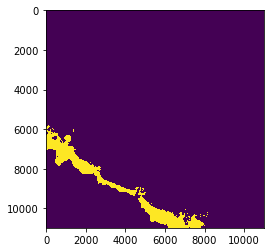

In [17]:
Lagoon = 'Mask/Lagoon.tif'

ClassifIndex = gdal.Open(ImagesFolder + Lagoon, gdal.GA_ReadOnly)
ClassifIndex = ClassifIndex.GetRasterBand(1).ReadAsArray().astype(bool)
print(ClassifIndex.shape)
plt.imshow(ClassifIndex)

## Create index(SurveyIndex) indicating the presence of measurements in a pixel
## Create dictionary(Dicto) of depths measured at a pixel location

In [18]:
# Create sub (2d) index for measured pixel
SurveyIndex = np.full(ClassifIndex.shape, 0, dtype=np.int8)
Dicto = {}
for i in range(len(px)):
    try:
        if ClassifIndex[py[i],px[i]] == False:
            continue
        SurveyIndex[py[i],px[i]] += 1
        if SurveyIndex[py[i],px[i]] == 1:
            Dicto[(py[i],px[i])] = [depth[i]]
        else:
            Dicto[(py[i],px[i])].append(depth[i])
    except:
        print(i)

## Compute Statistics on pixels containing measurements 

In [19]:
SurveyValues = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)
SurveyVariance = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)
for i, j  in Dicto.keys():
    SurveyValues[i, j] = np.mean(Dicto[(i, j)])
    SurveyVariance[i, j] = np.std(Dicto[(i, j)])

## Load Optical Data
### WARNING: Poe special case -> to avoid bigger backup size, data need to be resize at Rasters dimension

In [21]:
# Load Data at reduce backup size
npzfile = np.load('../../../Poe/CompressedData/SRXData.npz')
Xc = npzfile['Ratios'] # Optical data at croped shape (reduce backup size)
RatiosKeys = npzfile['Keys'] # Keys defining order of recorded ratios 

# Creation of arrays at Raster Size
X = np.full((RasterHeight, RasterWidth, Xc.shape[2]), np.nan) # Final array of optical data at Raster size 
ValidMap = np.full((RasterHeight, RasterWidth), False) # Map of area of Interest -> cropped area reducing backup size

# Translation of the data at the suitable dimension
X[5000:,0:8500,:] = Xc[:,:,:]
ValidMap[5000:,0:8500] = True
del Xc

# Useless here...
ToclassifyIndex = np.logical_and(ValidMap,ClassifIndex)
X.shape

MemoryError: 

## Special case in Poe, Area of interest for specific calibration manually created

In [ ]:
ShapeFolder = '../../../Poe/Shapes/'
RoiPathName = 'SheratonLagoon.shp'

ResctictedLagoon = mgp.create_mask_from_vector(ShapeFolder + RoiPathName,  RasterHeight, RasterWidth, GT_ds, proj, target_value=1, format=gdal.GDT_Byte)
ResctictedLagoon = ResctictedLagoon.GetRasterBand(1).ReadAsArray().astype(bool)
plt.imshow(ResctictedLagoon)

## Visual check !

In [ ]:
# Manual cropping for better visual rendering
ScatterIndex = np.logical_and(ResctictedLagoon[8800:9400,3500:4650],SurveyIndex[8800:9400,3500:4650]>0)
CroppedDepth = SurveyValues[8800:9400,3500:4650] # Average deph of pixels contained in the visual cropped

# Scatter coordinates and image in rendered dimension
y,x = np.where(ScatterIndex)
Im = SurveyValues[8800:9400,3500:4650]

# Plot
fig, ax = plt.subplots(figsize=(50,50))
plt.imshow(Im)
plt.scatter(x,y,s=80, c='r')
for i in range(len(x)):
    ax.annotate(CroppedDepth[ScatterIndex][i], (x[i]-10,y[i]+10), color='red', size=20)
print("Nombre de pixel comportant une mesure immergées:",len(x))

## Creation of calibration dataset

In [ ]:
assert X.shape[:2]==SurveyValues.shape
ind = ResctictedLagoon * (SurveyIndex>0) # Index of calibration data
Data_x = X[ind,:] # model optical descriptors
Data_y = SurveyValues[ind].reshape(np.sum(ind),) # model target depth

## release memory

In [ ]:
del X

## exploratory statistics

In [ ]:
for i in range(Data_x.shape[1]):
    print(str(RatiosKeys[i]),'correlation : ',np.corrcoef(Data_x[:,i],Data_y)[0,1])
    print("="*10)
mgp.plot_ResRegPlots(Data_x, Data_y, Scale=True, SetTitles=False, Titles=RatiosKeys)

In [ ]:
fig, axes = plt.subplots(2,5, figsize=(20, 8))
for i, ax in enumerate(fig.axes):
    ax.scatter(Data_x[:,i],Data_y, s=4)
    ax.set_title('Band  ' + str(RatiosKeys[i]))
    ax.set_ylabel('Depth')
    ax.set_xlabel('Optical Signal')

In [ ]:
x = Data_x
y = Data_y

In [ ]:
from scipy import stats
used_x = Data_x[:,1].reshape(len(y),)
plt.scatter(used_x,y)
buffer = np.array(stats.linregress(used_x,y)[:])
Interval = np.array([np.min(x),np.max(x)])
plt.plot(Interval, Interval*buffer[0]+buffer[1], c='k')
plt.xlabel('Optical Signal')
plt.ylabel('predicted Depth')


# Huber Regression

In [ ]:
lr = linear_model.RidgeCV(cv=115,fit_intercept=True, alphas= (10 ,0.1))

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = lr.fit(x, y).predict(x)

fig, ax = plt.subplots()
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
ax.scatter(y, predicted, s=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('R2 : '+str(r2_score(y, predicted)))
plt.show()

In [ ]:
lr.score(x,y)

# Simple Crossvalidated Linear model

In [ ]:
lr = linear_model.LinearRegression()

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
#predicted = cross_val_predict(lr, x, y, cv=len(y))
predicted = lr.fit(x, y).predict(x)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('R2 : '+str(r2_score(y, predicted)))
plt.show()

# Cross Validated RANSAC

In [ ]:
loo = LeaveOneOut()
loo.get_n_splits(x)
predicted = np.full(y.shape,np.nan, np.float)
inlierMat = np.full((y.shape[0], 1, len(y)),np.nan, np.float)
#lr = linear_model.RANSACRegressor(min_samples=0.9, max_trials=100000, residual_threshold=0.4,stop_probability=0.999)
lr = linear_model.RANSACRegressor(min_samples=0.5, residual_threshold=0.2)
counterCheck = 0


for train_index, test_index in loo.split(x):
    lr.fit(x[train_index], y[train_index])
    predicted[test_index] = lr.predict(x[test_index])
    inlierMat[train_index, 0, counterCheck] = lr.inlier_mask_
    counterCheck = counterCheck + 1
    
col = np.nansum(inlierMat, axis=2)
fig, ax = plt.subplots(figsize=(15,15))
im = ax.scatter(y, predicted,c=col, cmap='jet')
plt.colorbar(im)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('R2 : '+str(r2_score(y, predicted)))
plt.show()

# TheilSenRegressor

In [ ]:
loo = LeaveOneOut()
loo.get_n_splits(x)
predicted = np.full(y.shape,np.nan, np.float)
lr = linear_model.TheilSenRegressor()
counterCheck = 0

for train_index, test_index in loo.split(x):
    lr.fit(x[train_index], y[train_index])
    predicted[test_index] = lr.predict(x[test_index])
    counterCheck = counterCheck + 1
    
fig, ax = plt.subplots()
im = ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

# RANSAC Whithout cross validation

In [ ]:
lr = linear_model.RANSACRegressor(min_samples=0.9, max_trials=100000, residual_threshold=0.4,stop_probability=0.999)


# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = lr.fit(x, y).predict(x)

fig, ax = plt.subplots()
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
ax.scatter(y, predicted, c=lr.inlier_mask_, s=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
xIm,yIm = np.where(np.logical_and(ResctictedLagoon[8800:9400,3500:4650],SurveyIndex[8800:9400,3500:4650]>0))
y = SurveyValues[ind].reshape(np.sum(ind),)
plotInd = (col>5).reshape(len(y),)
ind = ResctictedLagoon[8800:9400,3500:4650]
fig = plt.figure(figsize=(50,50))
plt.imshow(ind)
plt.scatter(yIm[plotInd],xIm[plotInd],s=80, c='b')
plt.scatter(yIm[~plotInd],xIm[~plotInd],s=80, c='r')
print("Nombre de point extreme :",np.sum(~plotInd))

In [ ]:
testImage = testImage[8800:9400,3500:4650]**0.4

In [ ]:
xIm,yIm = np.where(np.logical_and(ResctictedLagoon[8800:9400,3500:4650],SurveyIndex[8800:9400,3500:4650]>0))
fig = plt.figure(figsize=(50,50))
plt.imshow(testImage)
plt.scatter(yIm,xIm,s=80, c='r')